In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
# arquivos Excel
pasta = "label_group_xlsx"

# arquivo master
arquivo_master = "master_clauses.csv"
df_master = pd.read_csv(arquivo_master)

In [3]:
# análise de palavras relevantes
def top_tfidf(df, tipo):
    vectorizer = TfidfVectorizer(max_features=30, stop_words='english')
    for categoria in df["categoria"].unique()[:5]:
        subset = df[df["categoria"] == categoria]["texto"]
        if len(subset) > 0:
            X = vectorizer.fit_transform(subset)
            palavras = vectorizer.get_feature_names_out()
            scores = X.mean(axis=0).A1
            top = pd.Series(scores, index=palavras).sort_values(ascending=False)[:15]
            plt.figure(figsize=(8,4))
            top.plot(kind="barh")
            plt.title(f"Top Palavras (TF-IDF) - {categoria} ({tipo})")
            plt.tight_layout()
            plt.show()

In [4]:
dados_contexto = []
dados_resposta = []

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".xlsx"):
        df = pd.read_excel(os.path.join(pasta, arquivo))
        colunas = df.columns[1:]
        for col in colunas:
            textos = df[col].dropna().astype(str)
            for t in textos:
                registro = {"arquivo": arquivo, "categoria": col, "texto": t}
                if col.lower().endswith("-answer"):
                    dados_resposta.append(registro)
                else:
                    dados_contexto.append(registro)

df_ctx = pd.DataFrame(dados_contexto)
df_rsp = pd.DataFrame(dados_resposta)

# Análise de contexto

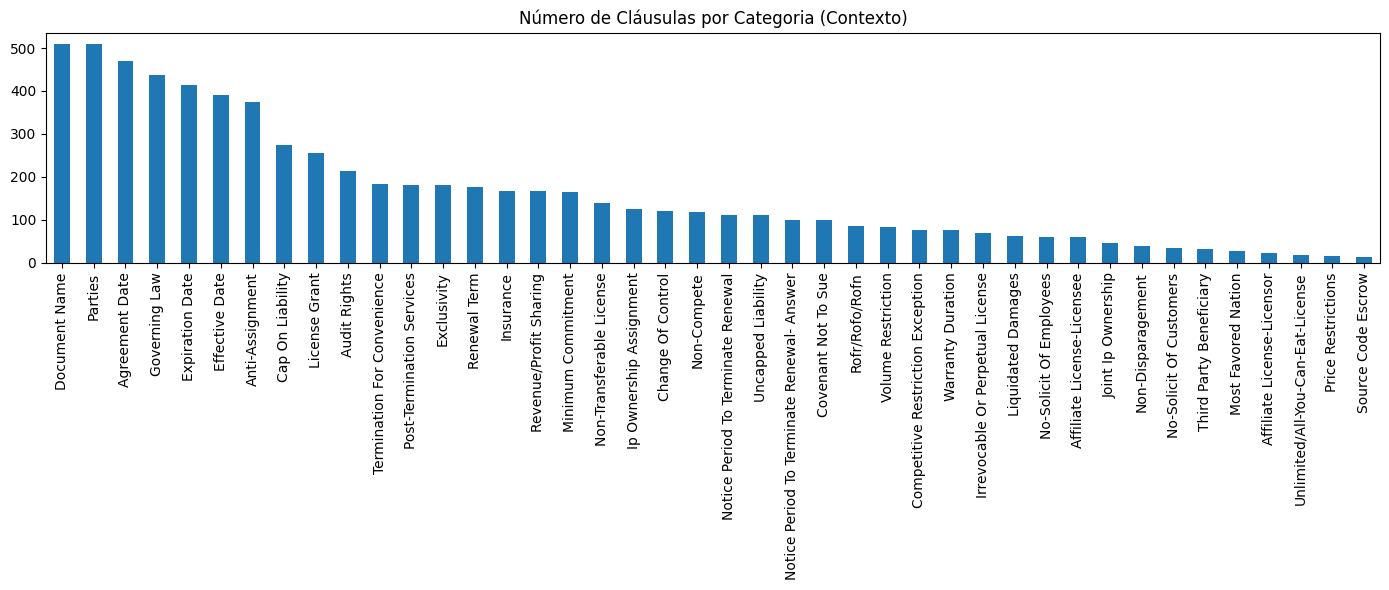

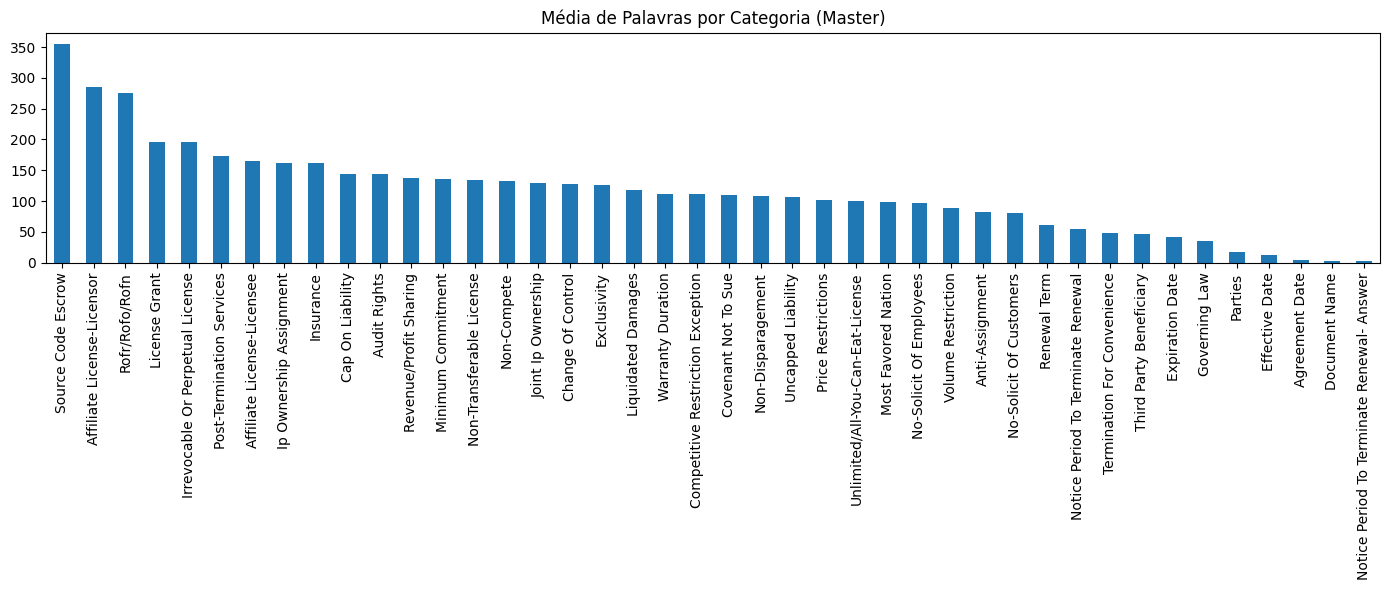

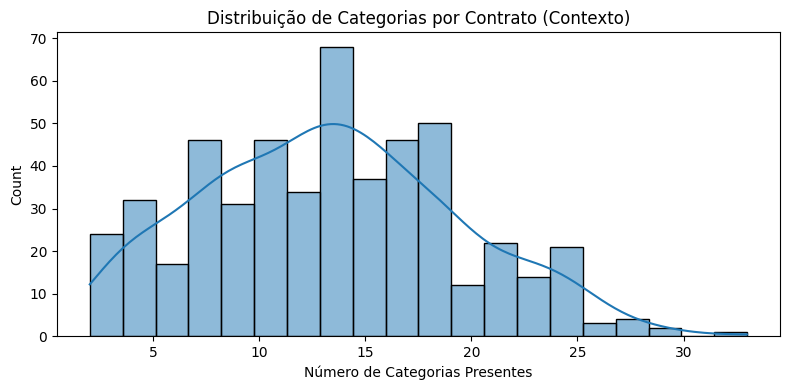

In [5]:
# Identifica colunas de contexto e resposta
df_master = df_master.replace('[]', pd.NA)
colunas_contexto = [c for c in df_master.columns[1:] if not c.lower().endswith("-answer")]
colunas_resposta = [c for c in df_master.columns[1:] if c.lower().endswith("-answer")]

num_clausulas_ctx = df_master[colunas_contexto].notna().sum().sort_values(ascending=False)
num_clausulas_ctx.plot(kind="bar", figsize=(14, 6), title="Número de Cláusulas por Categoria (Contexto)")
plt.tight_layout()
plt.show()

media_palavras_ctx = {
    c: df_master[c].dropna().astype(str).apply(lambda x: len(x.split())).mean()
    for c in colunas_contexto
}
pd.Series(media_palavras_ctx).sort_values(ascending=False).plot(kind="bar", figsize=(14, 6), title="Média de Palavras por Categoria (Master)")
plt.tight_layout()
plt.show()

# Distribuição de categorias por contrato
df_master["num_categorias_presentes"] = df_master[colunas_contexto].notna().sum(axis=1)
plt.figure(figsize=(8,4))
sns.histplot(df_master["num_categorias_presentes"], bins=20, kde=True)
plt.title("Distribuição de Categorias por Contrato (Contexto)")
plt.xlabel("Número de Categorias Presentes")
plt.tight_layout()
plt.show()

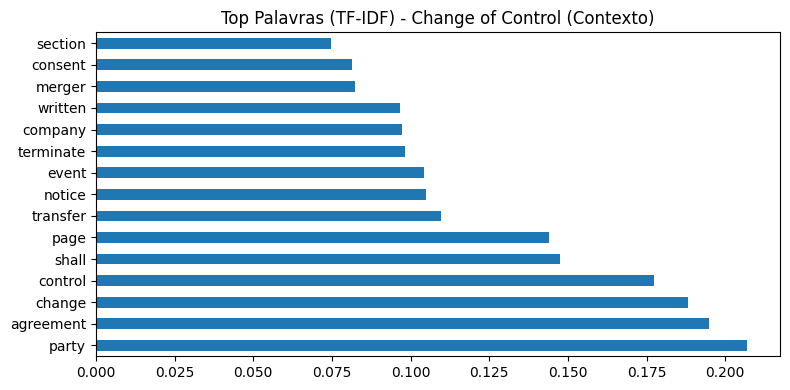

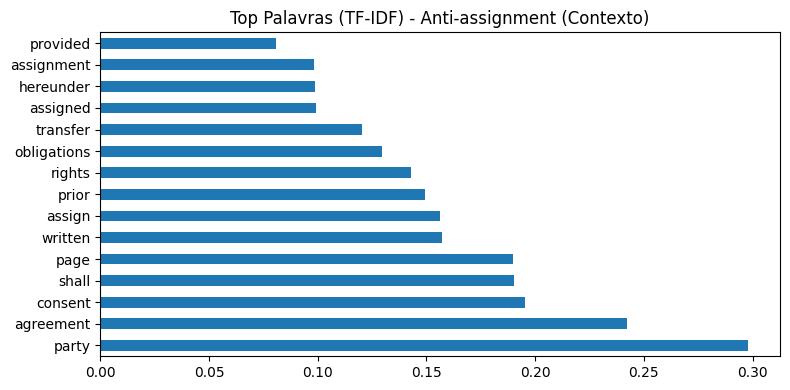

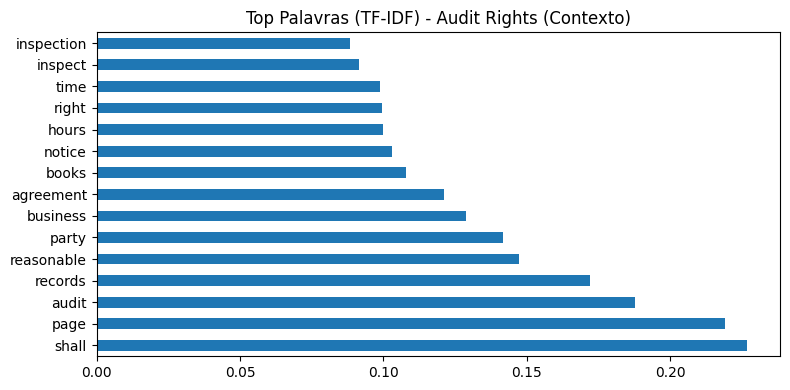

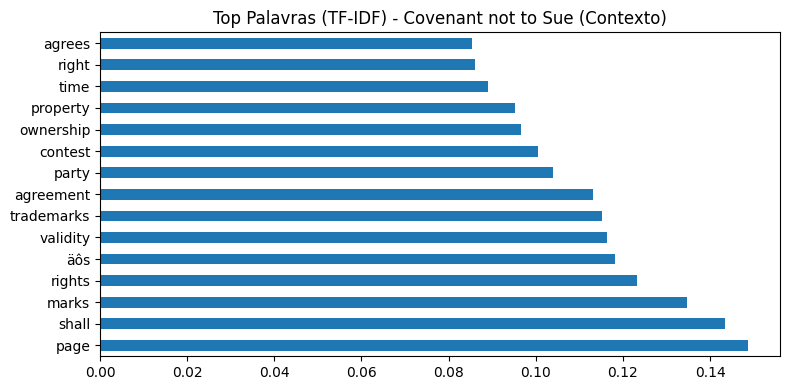

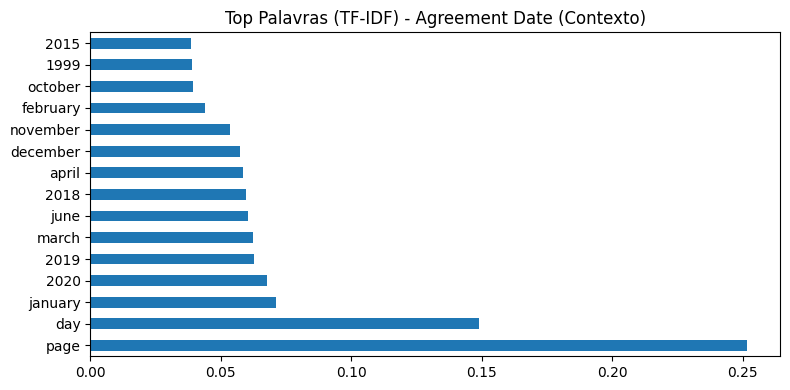

In [6]:
top_tfidf(df_ctx, "Contexto")

# Análise das respostas

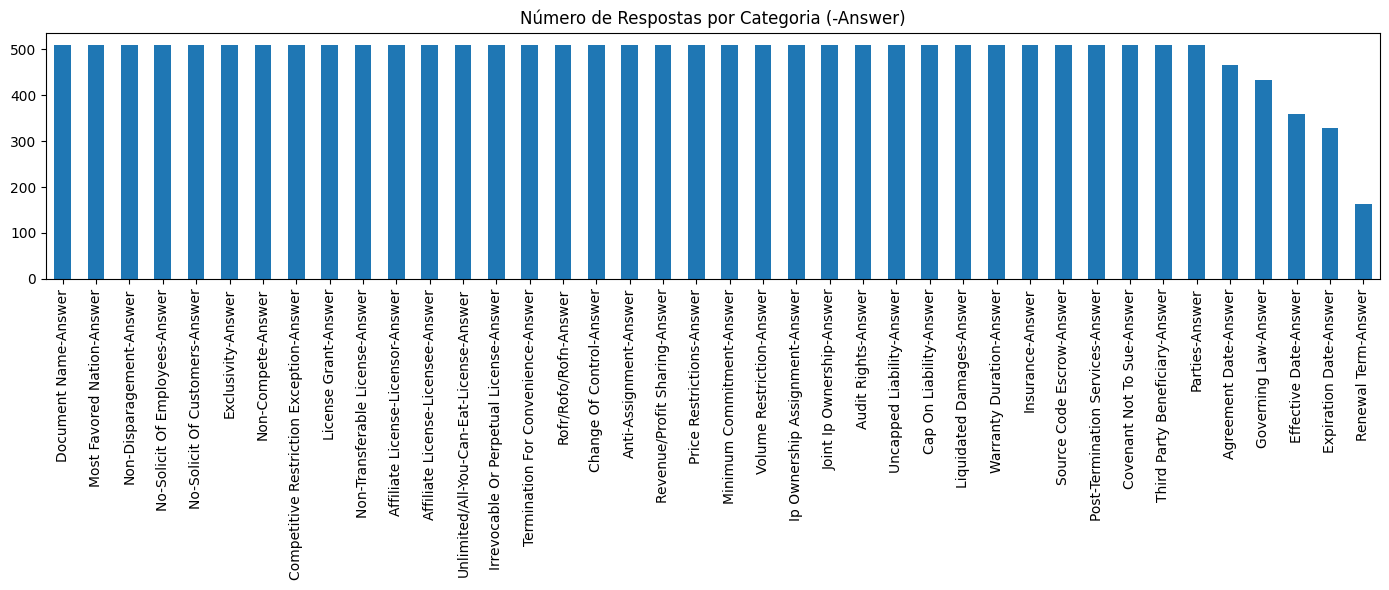

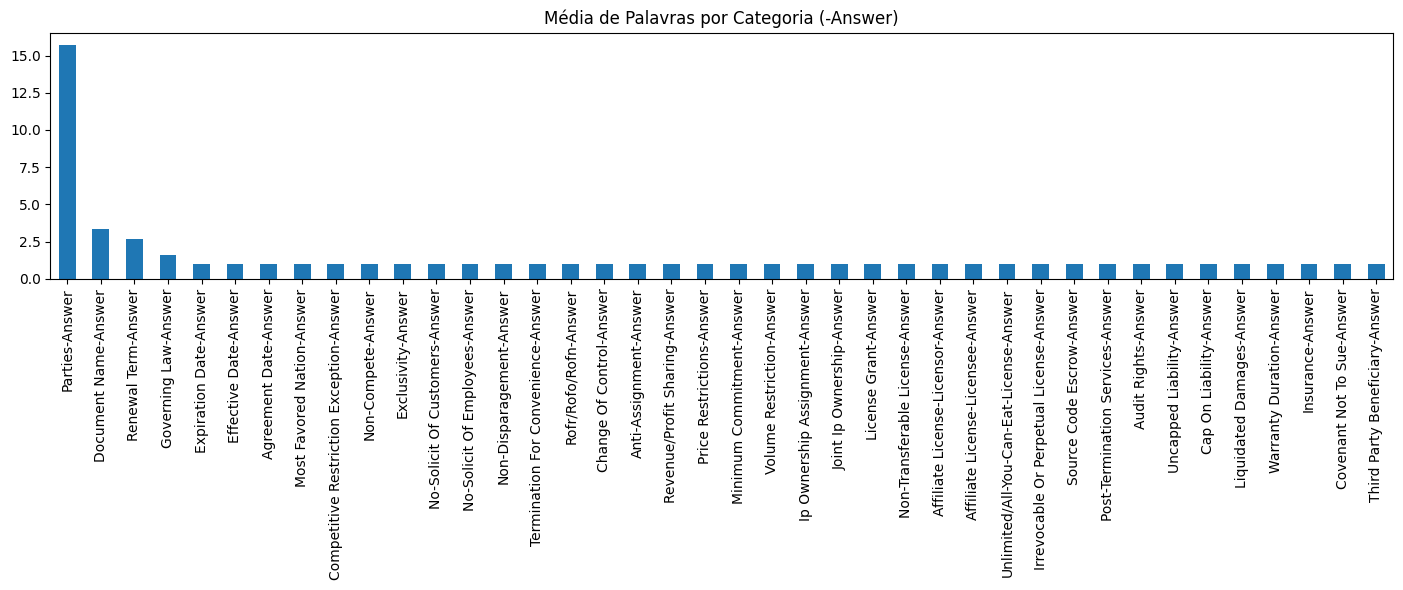

In [7]:
df_master = df_master.replace("[]", pd.NA)
num_clausulas_rsp = df_master[colunas_resposta].notna().sum().sort_values(ascending=False)
num_clausulas_rsp.plot(kind="bar", figsize=(14, 6), title="Número de Respostas por Categoria (-Answer)")
plt.tight_layout()
plt.show()

media_palavras_rsp = {
    c: df_master[c].dropna().astype(str).apply(lambda x: len(x.split())).mean()
    for c in colunas_resposta
}
pd.Series(media_palavras_rsp).sort_values(ascending=False).plot(kind="bar", figsize=(14, 6), title="Média de Palavras por Categoria (-Answer)")
plt.tight_layout()
plt.show()

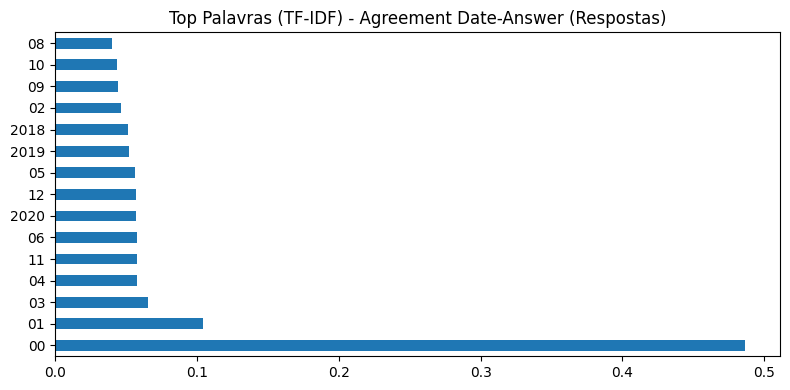

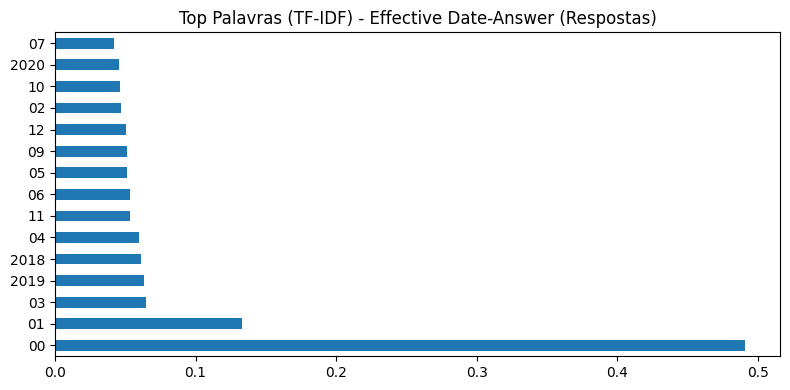

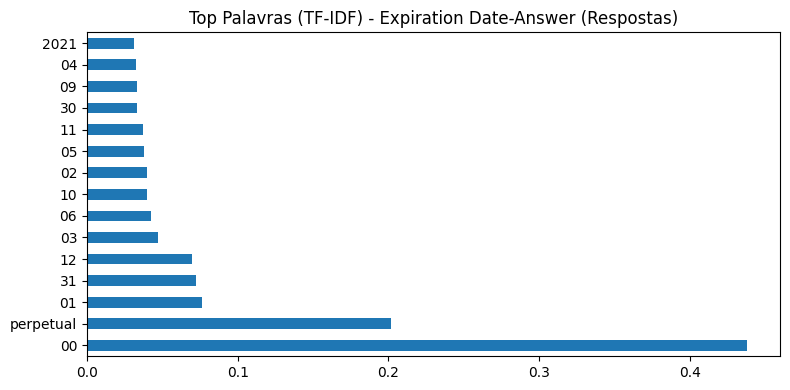

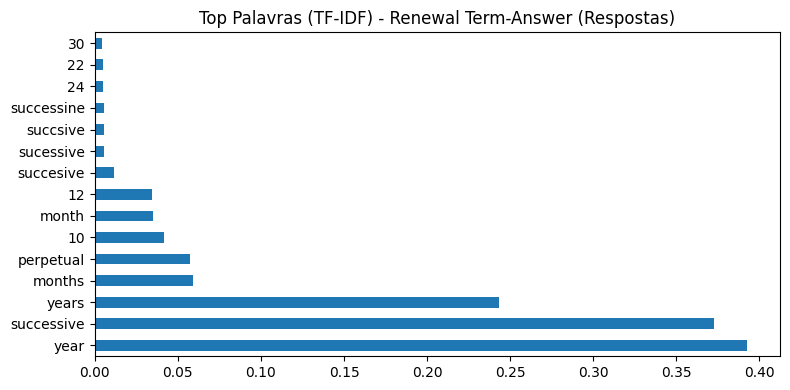

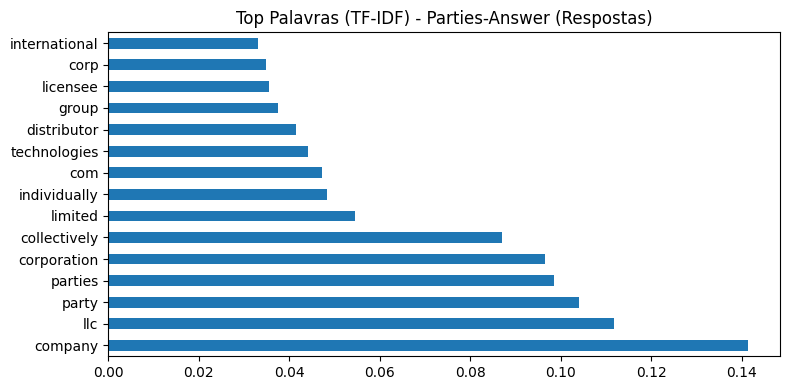

In [8]:
top_tfidf(df_rsp, "Respostas")

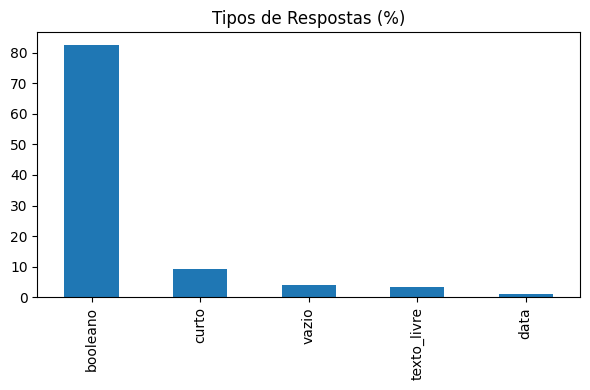

In [9]:
df = df_master

# apenas colunas que terminam com -Answer
colunas_resposta = [c for c in df.columns[1:] if c.lower().endswith("-answer")]

todas_respostas = df[colunas_resposta].astype(str).values.ravel()

def tipo_resposta(texto):
    texto = texto.strip().lower()
    if texto in ["yes", "no", "y", "n", "true", "false"]:
        return "booleano"
    elif re.match(r".*\d{4}-\d{2}-\d{2}.*", texto) or re.match(r".*\d{2}/\d{2}/\d{4}.*", texto) or re.match(r".*\d{2}/\d{2}/\d{2}.*", texto):
        return "data"
    elif texto == "" or texto == "nan":
        return "vazio"
    elif len(texto.split()) <= 3:
        return "curto"
    else:
        return "texto_livre"

tipos = pd.Series([tipo_resposta(x) for x in todas_respostas])

contagem_tipos = tipos.value_counts(normalize=True) * 100
contagem_tipos.plot(kind="bar", figsize=(6,4), title="Tipos de Respostas (%)")

plt.tight_layout()
plt.show()
